# Train a regression ConvNN model using BOHB tuner

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from ObservPredictor import * #ProcessObservationalDataset, ObsParameterPredictor
from DeepRegTrainer import TrainRegression
from StatVisAnalyzer import *

2023-07-25 14:47:45.383382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

# Step 1: Load the dataset

In [2]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [3]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


In [4]:
df.iloc[::10]

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.00,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
10,5.00,1100,0.25,1.7,8.540979e-09,9.610928e-09,8.362026e-09,6.331807e-09,5.411898e-09,3.597492e-09,...,2.589948e-09,1.400508e-09,1.423739e-09,1.331622e-09,5.718932e-10,2.525684e-09,2.577776e-09,2.171606e-09,1.170498e-09,no
20,5.00,1100,0.50,1.0,2.089233e-08,2.547443e-08,2.398659e-08,1.954245e-08,1.673706e-08,1.128757e-08,...,1.030422e-08,6.744711e-09,6.570654e-09,5.994584e-09,3.266539e-09,6.722988e-09,6.756289e-09,5.708415e-09,3.422240e-09,no
30,5.00,1100,1.00,0.5,3.773544e-08,4.306029e-08,3.789344e-08,2.982717e-08,2.555826e-08,1.704151e-08,...,3.370933e-08,2.475817e-08,2.292027e-08,2.084380e-08,1.293259e-08,1.818421e-08,1.723477e-08,1.401317e-08,8.880054e-09,no
40,5.00,1100,1.50,0.0,7.403044e-08,8.240733e-08,7.323895e-08,5.885655e-08,5.086389e-08,3.452053e-08,...,1.067845e-07,8.506743e-08,7.629151e-08,6.833675e-08,4.665959e-08,5.297000e-08,4.829532e-08,3.887601e-08,2.587082e-08,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30840,3.25,1000,1.00,-1.0,6.179704e-08,6.023661e-08,4.317990e-08,3.128656e-08,2.771920e-08,1.748527e-08,...,6.074206e-08,4.763676e-08,4.974581e-08,4.320090e-08,2.942153e-08,4.588604e-08,4.660016e-08,3.899730e-08,2.401752e-08,no
30850,3.25,1000,1.00,1.7,4.587650e-09,3.838308e-09,2.586146e-09,1.860407e-09,1.635306e-09,1.152218e-09,...,1.364340e-09,8.768095e-10,8.903187e-10,7.791423e-10,4.586279e-10,1.281345e-09,9.366753e-10,5.737637e-10,3.020979e-10,no
30860,3.25,1000,1.50,1.0,9.151923e-09,7.599074e-09,4.870096e-09,3.395405e-09,2.993091e-09,2.001870e-09,...,8.316857e-09,5.922216e-09,5.734787e-09,5.036230e-09,3.292385e-09,4.859911e-09,3.820969e-09,2.376922e-09,1.196810e-09,no
30870,3.25,1000,2.00,0.5,1.755109e-08,1.456820e-08,9.125922e-09,6.253583e-09,5.540055e-09,3.570220e-09,...,3.041929e-08,2.417082e-08,2.437794e-08,2.183006e-08,1.552078e-08,1.638151e-08,1.205167e-08,7.349473e-09,3.697040e-09,no


## Prepare feature variables (X) and targets (y)

In [5]:
df = df[df['is_augmented'].isin(['no'])]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [6]:
y['temperature'] = np.log10(y['temperature'])

/tmp/ipykernel_4347/3354840019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['temperature'] = np.log10(y['temperature'])


In [7]:
# print( 'skewness:' )
# display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
# y.hist(grid=True, bins=19);

In [8]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Data Processing

In [9]:
# Create an instance of TrainCNNRegression
train_cnn_regression = TrainRegression(feature_values=X,
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

In [10]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [11]:
# normalize the X features using MinMax Scaler
train_cnn_regression.standardize_X_row_wise()

In [12]:
# train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_train_standardized_rowwise, xticks_list = None)

In [13]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

In [15]:
# train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.y_train_standardized_columnwise)

In [16]:
# train_cnn_regression.y_train_standardized_columnwise

In [17]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [18]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [19]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [20]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [21]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [22]:
df_MinMax_train.head()

,min,max
28744,8.265340e-12,3.445259e-08
6288,8.080712e-22,8.397132e-14
13749,2.734403e-07,8.632182e-06
11713,4.414951e-16,3.373262e-10
15538,3.722576e-07,6.859888e-06


In [23]:
# plt.loglog(train_cnn_regression.X_train_max, 'k.', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train, 'r.', label='X_train', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train_min, 'r.', alpha = 0.4)

---

In [24]:
train_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

In [26]:
# train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_test_standardized_columnwise)

# Step 3: Load the Trained CNN model

## Load Saved Models

In [27]:
# model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters_v1.h5')
# model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters_v1.h5')

# # Loading the saved history object
# with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters_v1.pkl', 'rb') as file:
#     history = pk.load(file)    

In [28]:
model = load_model('../../outputs/trained_models/my_model_architecture__xStand_yStand_MinMax_v2.h5')
model.load_weights('../../outputs/trained_models/my_model_weights__xStand_yStand_MinMax_v2.h5')

# Loading the saved history object
with open('../../outputs/trained_models/training_history__xStand_yStand_MinMax_v2.pkl', 'rb') as file:
    history = pk.load(file)    

2023-07-25 14:48:35.580310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 14:48:35.589171: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [29]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

# Step 4: Check Trained Model

---

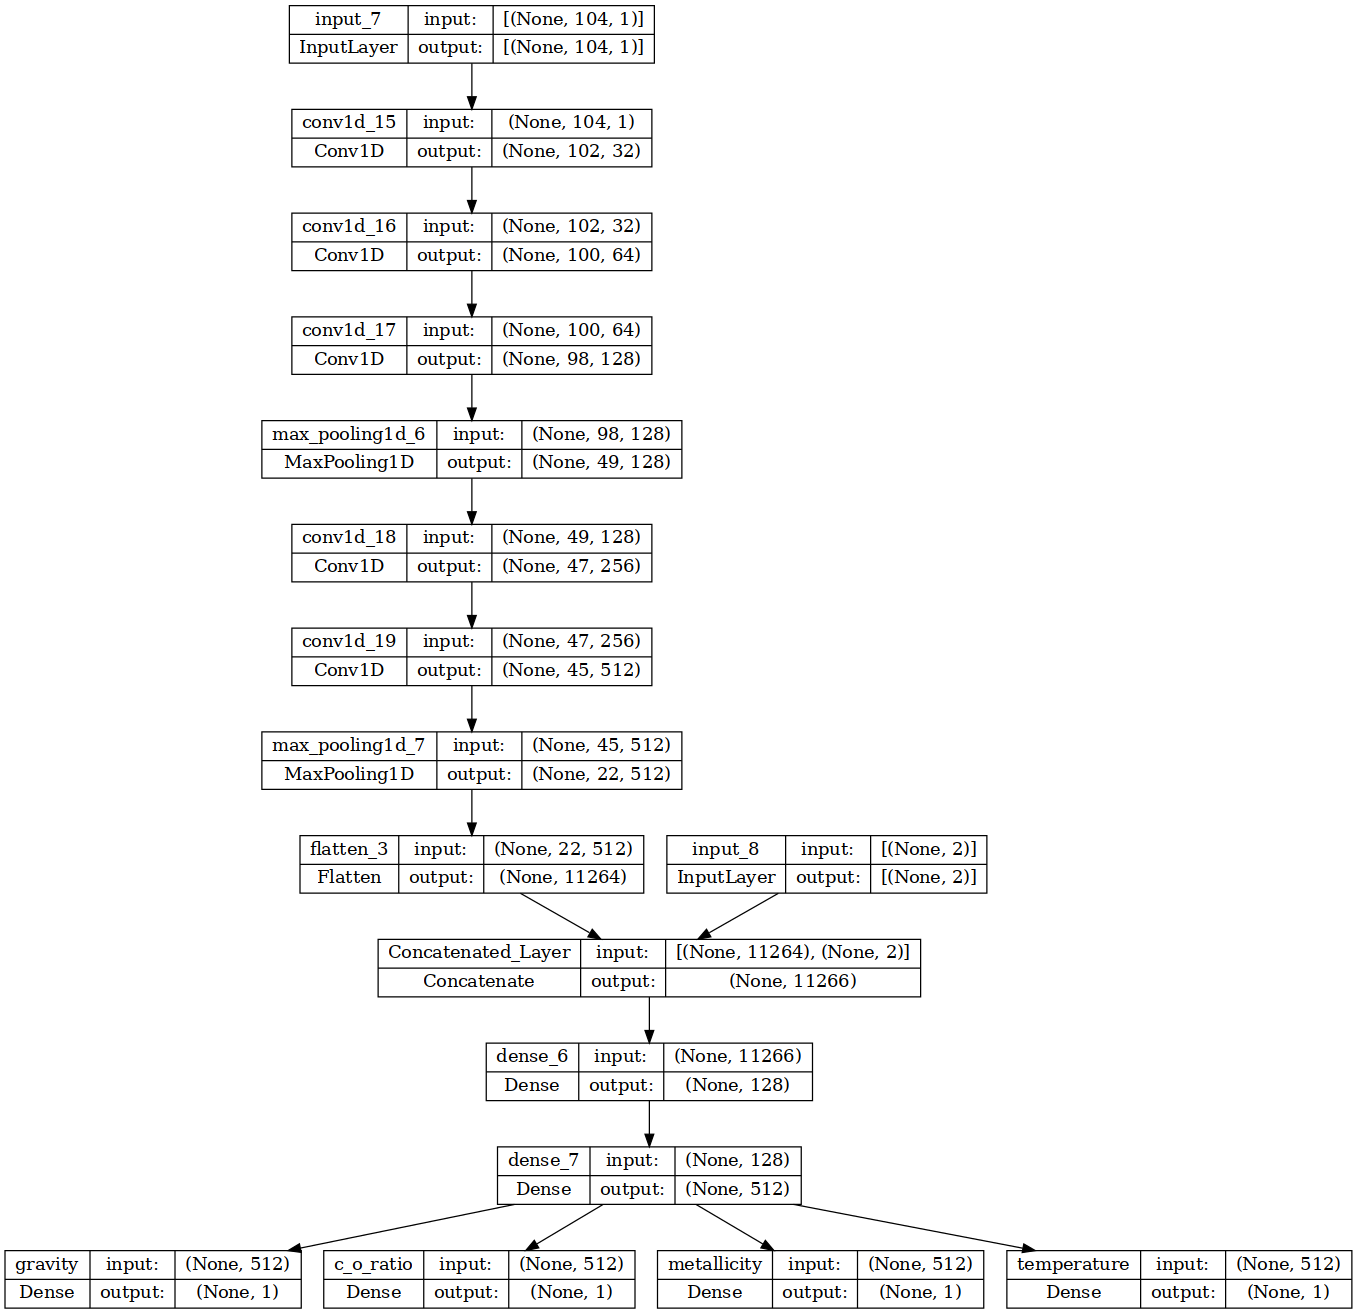

In [30]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
                show_layer_activations=False,
)

In [31]:
train_cnn_regression.trained_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 104, 1)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 102, 32)      128         ['input_7[0][0]']                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 100, 64)      6208        ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_17 (Conv1D)             (None, 98, 128)      24704       ['conv1d_16[0][0]']              
                                                                                            

In [32]:
train_cnn_regression.plot_model_loss(title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

In [33]:
# train_cnn_regression.plot_model_loss(title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot Y predicted vs Y_Actual: Histogram & Scatter plot

In [34]:
# i = 199
# regression_report(
#         trained_model = train_cnn_regression,
    
#         Xtrain = [train_cnn_regression.X_train_standardized_rowwise[::i],
#                   train_cnn_regression.X_train_standardized_columnwise[::i]],
    
#         Xtest  = [train_cnn_regression.X_test_standardized_rowwise[::i], 
#                   train_cnn_regression.X_test_standardized_columnwise[::i]],
    
#         ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
#         ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
#         target_i = 4,
        
#         xy_top   = [0.05, 0.7],
#         xy_bottom= [0.05, 0.85],
#         print_results = False,        
#                  )

# Step 5: Predict Observational data using the trained model

## ROSS 458C

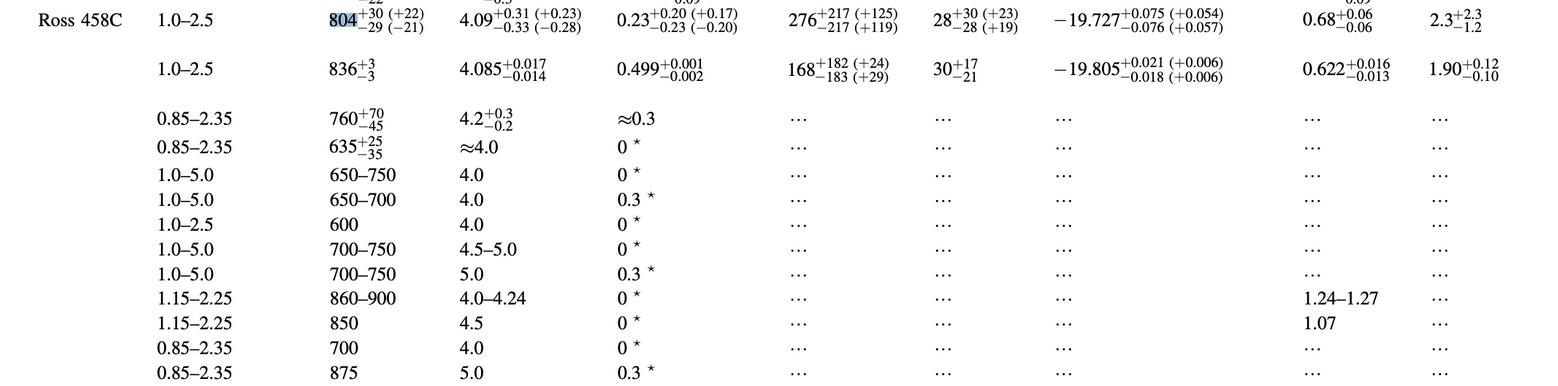

---

Steps: 
- Define the literature reported data for the object
- Instintiate ObsParameterPredictor class
- load_observational_spectra
    - replace negative Flam with zero
    - take the average of neibougrs for Flam_error <= 0
    - plot_observational_spectra_errorbar_
- Process_Observational_Dataset
    - Instintiate ProcessObservationalDataset class
    - define feature_names_synthetic and feature_names_obs
    - flux_interpolated
    - 

In [40]:
# define the brown dwarf literature data for Teff, logg, [M/H], and C/O
# ... and also the distance to the object [in pc] and its radius in Rjup
HD3651B_BD_literature_info = {'bd_name':'HD3651B',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 11.134, 
          'bd_radius_Rjup' : 1.0 * 0.81 } 

Ross458C_BD_literature_info = {'bd_name':'Ross458C',
          'bd_Teff':804,
          'bd_logg':4.09,
          'bd_met': 0.23, 
          'bd_distance_pc' : 11.509, 
          'bd_radius_Rjup' :  0.64 } #1.0 * 0.68 

GJ570D_BD_literature_info = {'bd_name':'GJ570D',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 5.884, 
          'bd_radius_Rjup' : 0.98 } #1.06*0.79

In [41]:
brown_dwarf_literature_info = GJ570D_BD_literature_info
predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = df,
                                wl = wl, 
                                train_cnn_regression_class = train_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [42]:
predict.load_observational_spectra()

In [43]:
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=True,
    )

In [44]:
predict.predict_from_random_spectra(random_spectra_num= 20,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.7367820739746094,
    'gravity': 5.291966438293457,
    'metallicity': -0.39895039796829224,
    'temperature': 794.8287963867188}
******************************



,logg,c_o,met,T
count,20.000000,20.000000,20.000000,20.000000
mean,5.291966,1.736782,-0.398950,794.828796
std,0.171622,0.174732,0.058745,31.002768
min,4.929297,1.381357,-0.527709,722.773743
25%,5.206524,1.662378,-0.428400,774.886856
50%,5.302354,1.734155,-0.397795,809.261200
75%,5.353052,1.865087,-0.383973,811.795197
max,5.727402,2.083615,-0.272789,845.043701


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 300x300 with 2 Axes>

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 300x300 with 2 Axes>

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 300x300 with 2 Axes>

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 300x300 with 2 Axes>

# Optimize the Object Radius

In [45]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.98 R_Jup:  𝛘2 = 117.57, p-value = 1.55e-01


(117.57, '1.55e-01')

In [46]:
import math

def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = df,
                                        wl = wl, 
                                        train_cnn_regression_class = train_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_two_lines_with_twin_y(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [47]:
brown_dwarf_literature_info

{'bd_name': 'GJ570D',
 'bd_Teff': 818,
 'bd_logg': 3.94,
 'bd_met': -0.22,
 'bd_distance_pc': 5.884,
 'bd_radius_Rjup': 0.98}

In [50]:
conda update seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.2



## Package Plan ##

  environment location: /home/egharibn/anaconda3/envs/bohb

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ffmpeg-4.2.2               |       h20bf706_0        59.6 MB
    fontconfig-2.14.1          |       h4c34cd2_2         281 KB
    libclang-14.0.6            |default_hc6dbbc7_1         137 KB
    libclang13-14.0.6          |default_he11475f_1         9.8 MB
    librsvg-2.54.4             |       h36cc946_3         6.0 MB
    libxkbcommon-1.0.1         |       h5eee18b_1         590 KB
    libxml2-2.10.3           

In [48]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.4, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.4, dR=0.02,
                                                   brown_dwarf_literature_info = brown_dwarf_literature_info)

Radius = 0.78 R_Jup:  𝛘2 = 215.82, p-value = 5.46e-10
Radius = 0.81 R_Jup:  𝛘2 = 505.32, p-value = 0.00e+00
Radius = 0.85 R_Jup:  𝛘2 = 409.94, p-value = 0.00e+00
Radius = 0.88 R_Jup:  𝛘2 = 509.8, p-value = 0.00e+00
Radius = 0.91 R_Jup:  𝛘2 = nan, p-value = nan
Radius = 0.95 R_Jup:  𝛘2 = 103.8, p-value = 4.59e-01
Radius = 0.98 R_Jup:  𝛘2 = 80.49, p-value = 9.51e-01
Radius = 1.01 R_Jup:  𝛘2 = 593.28, p-value = 0.00e+00
Radius = 1.05 R_Jup:  𝛘2 = 117.74, p-value = 1.52e-01
Radius = 1.08 R_Jup:  𝛘2 = 104.53, p-value = 4.39e-01
Radius = 1.11 R_Jup:  𝛘2 = 131.09, p-value = 3.23e-02
Radius = 1.15 R_Jup:  𝛘2 = 394.39, p-value = 0.00e+00


Radius = 1.18 R_Jup:  𝛘2 = 186.3, p-value = 9.59e-07


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 400x400 with 1 Axes>

In [275]:
closest_chi_square, closest_p_value = find_closest_chi_square(df_value, chi_square_list)

print("Closest Chi-Square Statistic:", closest_chi_square)
print("P-value:", closest_p_value)

Closest Chi-Square Statistic: 121.09
P-value: 0.10764070921380597


---

# END ------